## Model simulation interface

Here, we introduce a Jupyter-based interface designed for model simulation. This interface allows for the simulation of three different COVID-19 scenarios — moderate, severe, and critical based on age-related risk factors, collectively referred to as the **Baseline** simulation. Moreover, each disease progression scenario includes 9 additional conditions, covering both impaired and enhanced immune function:

### Impaired:
1. **Macrophage hyperactivation**. We increase the parameters $a_{Mr_{Ma}}$ and $p_{Mr}$, which represent macrophage recruitment and activation rates, respectively.
2. **Innate immune response delay**. We increase the $t_{IDC}$ parameter, which denotes the rate of dendritic cell migration and maturation.
3. **CD4+ T cell depletion**. We simulate a reduction in the number of naive CD4+ T cells, similar to the effect observed during HIV.
4. **Impaired T cell development**. We simulate a decrease in T cell proliferation rates $p_{CD4}$ and $p_{CD8}$, as observed during immune suppression therapy for organ transplantation.
5. **Enhanced viral infectivity**. We increase viral infectivity $i_{V_{EP}}$ and decrease the neutralization activity $e_{V_{Ig}}$ of antibodies.

### Enhanced:
6. **Enhanced CTL activity**. We boost the rate of epithelial cell elimination by CTLs, represented by $e_{EPi_{CTL}}$.
7. **Enhanced CTL activity**. We enhance the rate of virion neutralization by antibodies, denoted by $e_{V_{Ig}}$. 
8. **Interferon administration**. We implemented interferon administration for 5 days following the symptoms onset.
9. **Inhibited viral replication**. We decrease the viral replication rate $r_{V_{EP}}$, simulating the effect of a drug administration for 5 days after symptoms onset.

In [15]:
"""
Instructions:

1. Run all initialization cells
2. Run this cell
3. Set settings and start simulation
"""

out = widgets.Output()
display(severity_buttons, experiment_buttons, start_butto, out)

ToggleButtons(description='Disease severity:', options=('Moderate', 'Severe', 'Critical'), style=ToggleButtons…

ToggleButtons(description='Experiment:', index=6, layout=Layout(width='auto'), options=('Baseline', 'Macrophag…

Button(button_style='success', description='Start simulation', layout=Layout(display='block', margin='0px 0px …

completed


---

## Initialization cells

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import clear_output
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor
from nbconvert import PythonExporter
import threading
import time
import os

In [2]:
def on_toggle_change(event):
    display(severity_buttons, experiment_buttons, start_button)
    if severity_buttons.value == "Moderate":
        if experiment_buttons.value == 'Baseline':
            create_plot('simulation_results/baseline/baseline_moderate.csv', severity_buttons.value)
        else:
            create_exp_plot(severity_buttons.value, experiment_buttons.value, 'simulation_results/baseline/baseline_moderate.csv')
    elif severity_buttons.value == "Severe":
        if experiment_buttons.value == 'Baseline':
            create_plot('simulation_results/baseline/baseline_severe.csv', severity_buttons.value)
        else:
            create_exp_plot(severity_buttons.value, experiment_buttons.value, 'simulation_results/baseline/baseline_severe.csv')

    elif severity_buttons.value == "Critical":
        if experiment_buttons.value == 'Baseline':
            create_plot('simulation_results/baseline/baseline_critical.csv', severity_buttons.value)
        else:
            create_exp_plot(severity_buttons.value, experiment_buttons.value, 'simulation_results/baseline/baseline_critical.csv')

In [4]:
def format_tick(value, pos):
    if value == 0:
        return r"${0}$"
    exponent = int(np.floor(np.log10(np.abs(value))))
    coefficient = value / 10**exponent
    if coefficient % 1.0 == 0.0:
        return r"${} \times 10^{}$".format(int(coefficient), exponent)
    else:
        rend_coeff = '{:.1f}'.format(coefficient)
        return r"${} \times 10^{}$".format(rend_coeff, exponent)

def format_tick_ab(x, pos):
    if x.is_integer():
        return f'{int(x)}'
    else:
        return f'{x:.1f}'
    
def format_tick_v(x, pos):
    exponent = int(np.floor(np.log10(np.abs(x))))
    return r"$10^{}$".format(exponent)
    
def load_and_sort_csv_exp(dir, suffix):
    files = [file for file in os.listdir(dir) if file.endswith(suffix)]
    files.sort(key=lambda x: int(x.split('_')[1]))
    return [pd.read_csv(os.path.join(dir, file)) for file in files]
    

title_fs = 24
axes_labels_fs = 20
legend_fs = 24
tick_labels_fs = 20
log_tick_labels_fs = 20

tick_pad = 10
title_pad = 17
label_pad = 9
colorbar_pad = 0.12


curves_width = 3.5
outline_width = 0.1

In [5]:
plt.rcParams.update({
    'axes.titlesize': title_fs,  
    'axes.labelsize': axes_labels_fs,
    'xtick.labelsize': tick_labels_fs, 
    'ytick.labelsize': tick_labels_fs,
    'axes.labelpad': label_pad, 
    'xtick.major.pad': tick_pad,
    'ytick.major.pad': tick_pad, 
    'axes.titlepad': title_pad,
    'text.usetex': False,
})

In [6]:
colors_modes = {'Moderate' : "#009fb7",
               'Severe' : "#f6ae2d",
               'Critical' : "#fe4a49"}
vars_names = {
    "v" : "Viral load (UA)", "ep" : "Epithelial cells (UA)", "epe" : "Exposed epithelial cells", 
    "epi" : "Infected epithelial cells", "idc" : "Immature dendritic cells", "mdc" : "Mature DCs",
    "tn" : "Naïve CD8+ T cells", "ctl" : "Cytotoxic T cells (LN)", "ctl_ua" : "CTLs at the site of infection", 
    "bn" : "Naïve B cells", "p" : "Plasma cells", "ab" : "Immunoglobulins", "v_l" : "Viral load (Lungs)", "ep_l" : "Epithelial cells (Lungs)",
    "epe_l" : "Exposed epithelial cells", "epi_l" : "Infected epithelial cells", "idc_l" : "Immature dendritic cells",
    "mdc_l" : "Mature DCs", "cd4n_l" : "Naïve CD4+ T cells", "cd8n_l" : "Naïve CD8+ T cells",
    "ctl_l" : "Cytotoxic T cells (LN)", "th1_l" : "Th1 cells", "tfh_l" : "Tfh cells",
    "ctl_site_l" : "Cytotoxic T cells (Lungs)", "bn_l" : "Naïve B cells", "p_l" : "Plasma cells", "abg_l" : "Immunoglobulin G",
    "aba_l" : "Immunoglobulin A", "abm_l" : "Immunoglobulin M", "mr_l" : "Resting macrophages", "ma_l" : "Activated macrophages",
    "igamma_l" : "Interferon gamma", "i2_l" : "Interleukin 2", "i6_l" : "Interleukin 6",  "i12_l" : "Interleukin 12"
}

var_to_plot_l = ["v", "v_l", "ep", "ep_l",
                 "i6_l", "igamma_l", "mdc_l", "ma_l",
                 "abm_l", "abg_l", "ctl_l", "th1_l"]

var_labels = ["RNA copies/ml", "RNA copies/ml", "cells", "cells",
              "pg/ml", "pg/ml", "cells/ml", "cells/ml",
              "μg/ml", "μg/ml", "cells/ml", "cells/ml"]

In [7]:
def delayed_print(message, delay_seconds):
    time.sleep(delay_seconds)
    print(message)

def create_plot(csv_name, severity):
    out.clear_output()
    with out:
        print("Plotting...", end='')
    alphas = 0.45
    siz = 20
    
    df = pd.read_csv(csv_name)
    df_moderate = pd.read_csv('simulation_results/baseline/baseline_moderate.csv')
    
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(24, 17), dpi=300)
    fig.suptitle(f'{severity} COVID-19', fontsize=34)
    for ind, ax in enumerate(axs.flat):
        curve, = ax.plot(df.t, df[var_to_plot_l[ind]], zorder=6, lw=curves_width, color=colors_modes[severity])
        if severity in ["Severe", "Critical"]:
            baseline, = ax.plot(df_moderate.t, df_moderate[var_to_plot_l[ind]], zorder=6, lw=curves_width, color="#009fb7")
        ax.set_title(vars_names[var_to_plot_l[ind]])
        ax.set_xlabel("time, days after infection")
        ax.set_ylabel(var_labels[ind])
        ax.set_xlim(0, 60)
        if var_to_plot_l[ind] in ["v_l", "v"]:
            ax.set_ylim(1e3, 1e9)
            ax.yaxis.set_major_formatter(FuncFormatter(format_tick_v))
            ax.set_yscale('symlog')
        elif var_to_plot_l[ind] in ["mdc_l", "ma_l", "ep_l", "ep", "ctl_site_l", "tfh_l", "p_l"]:
            ax.yaxis.set_major_formatter(FuncFormatter(format_tick))
        elif var_to_plot_l[ind] in ["i6_l", "igamma_l", "i2_l", "i12_l"]:
            ax.yaxis.set_major_formatter(FuncFormatter(format_tick_ab))
        elif var_to_plot_l[ind] in ["ctl_l", "th1_l"]:
            ax.yaxis.set_major_formatter(FuncFormatter(format_tick))
        elif var_to_plot_l[ind] in ["abg_l", "aba_l", "abm_l"]:
            ax.yaxis.set_major_formatter(FuncFormatter(format_tick_ab))
            ax.set_yscale('symlog')
    
    for ind, ax in enumerate(axs.flat):
        max_val_mod = max([max(df[var_to_plot_l[ind]]), max(df_moderate[var_to_plot_l[ind]])])
        ax.grid(which="major", color="lightgray", linestyle="-", linewidth=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        if var_to_plot_l[ind] in ["v_l", "v"]:
            ax.set_ylim(1e3, 1e9)
        elif var_to_plot_l[ind] in ["abg_l", "aba_l", "abm_l"]:
            ax.set_ylim(1, 30)
        else:
            ax.set_ylim(0, max_val_mod * 1.05)

    if severity in ['Severe', 'Critical']:
        fig.legend(handles=(curve, baseline), labels=(severity + ' progression', 'Moderate progression'), loc='lower center', fontsize=24, borderaxespad=-0.001, ncol=2)
  
    plt.subplots_adjust(wspace=0.6, hspace=0.6)
    with out:
        plt.show()

ToggleButtons(description='Disease severity:', options=('Moderate', 'Severe', 'Critical'), style=ToggleButtons…

ToggleButtons(description='Experiment:', index=6, layout=Layout(width='auto'), options=('Baseline', 'Macrophag…

Button(button_style='success', description='Start simulation', layout=Layout(display='block', margin='0px 0px …

Plotting...

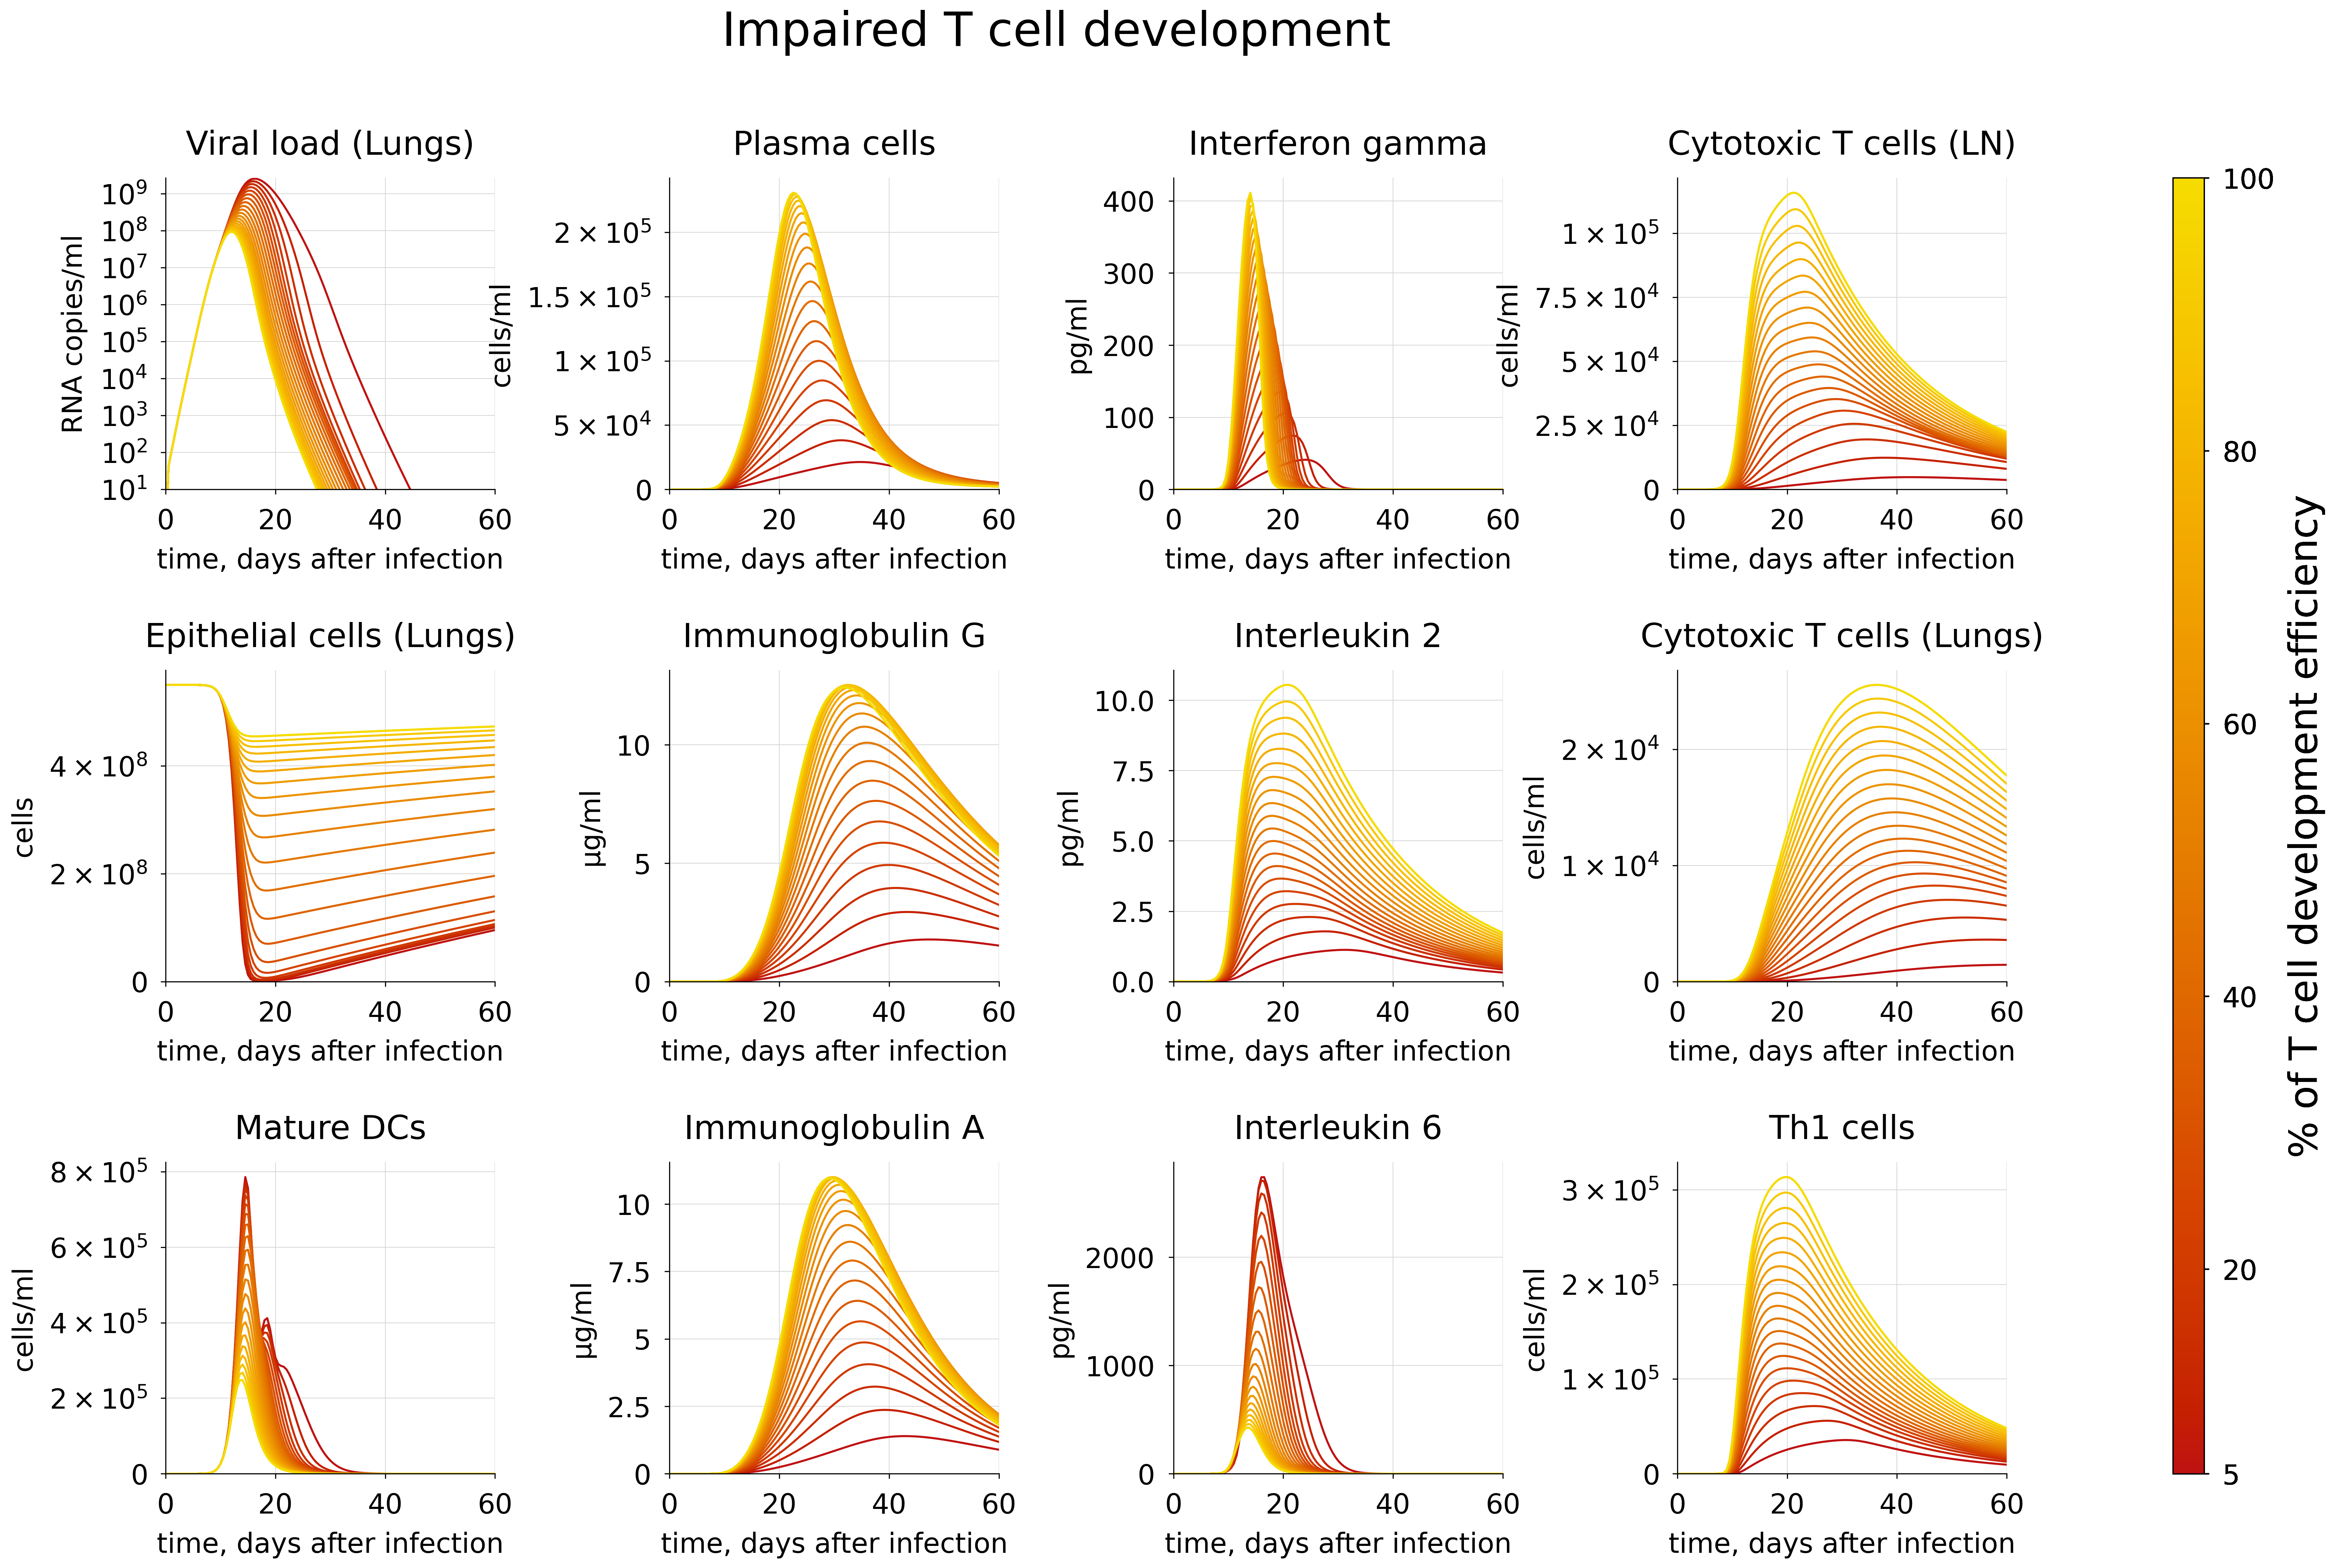

In [ ]:
severity_buttons = widgets.ToggleButtons(
    options=['Moderate', 'Severe', 'Critical'],
    description='Disease severity:',
    disabled=False,
    style={'description_width': '100px'},
    button_style=''
)
experiment_buttons = widgets.ToggleButtons(
    options=['Baseline', 'Macrophage hyperactivation', 'Innate immune response delay', 'Enhanced CTL activity', 'Enhanced antibody activity', 'CD4+ T cell depletion', 'Impaired T cell development', 'Enhanced viral infectivity', 'Interferon administration', 'Inhibited viral replication'],
    description='Experiment:',
    disabled=False,
    layout=widgets.Layout(width='500px'),
    style={'description_width': '100px', "button_width": "224px"},
    button_style=''
)

start_button = widgets.Button(
    description='Start simulation',
    disabled=False,
    button_style='success',
    tooltip='Start simulation',
    style={"button_width": "500px"},
    layout=widgets.Layout(
        width='455px',
        margin='8px 5px 0px 0px',
        display='block' 
    )
)
text_widget = widgets.Label(value="Plots will appear shortly...")
start_button.on_click(on_toggle_change)

In [9]:
def load_and_sort_csv_exp(dir, suffix):
    files = [file for file in os.listdir(dir) if file.endswith(suffix)]
    files.sort(key=lambda x: int(x.split('_')[1]))
    return [pd.read_csv(os.path.join(dir, file)) for file in files]

In [10]:
# Macrophage hyperactivation
cb_scale_mh = [4.0, 14.0, 24.0, 34.0, 44.0, 54.0]
cb_1_names_mh = ["54", "44", "34", "24", "14", "4"]
cb_2_names_mh = ["0.5", "0.46", "0.42", "0.38", "0.34", "0.3"]
cb_vars_mh = ["${p_{Mr}}$", "${a_{Mr_{Ma}}}$"]

# Innate immune response delay
cb_scale_ird = [0.8, 1.0, 1.2, 1.4, 1.6, 1.8]
cb_1_names_ird = ["1.8", "1.6", "1.4", "1.2", "1.0", "0.8"]
cb_vars_ird = ["${t_{IDC}}$"]

# Enhanced CTL activity
cb_scale_ca = [0.005, 0.009, 0.013, 0.017, 0.021, 0.025]
cb_1_names_ca = ["0.025", "0.021", "0.017", "0.013", "0.009", "0.005"]
cb_vars_ca = ["${e_{EPi_{CTL}}}$"]

# Enhanced antibody activity
cb_scale_aa = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
cb_1_names_aa = ["1.5", "1.3", "1.1", "0.9", "0.7", "0.5"]
cb_vars_aa = ["${e_{V_{Ig}}}$"]

# CD4+ T cells depletion
cb_scale_cd4 = [5, 20, 40, 60, 80, 100]
cb_1_names_cd4 = ["5", "20", "40", "60", "80", "100"]
cb_vars_cd4 = ["% of naive CD4+ T cells"]

# Impaired T cell development
cb_scale_td = [5, 20, 40, 60, 80, 100]
cb_1_names_td = ["5", "20", "40", "60", "80", "100"]
cb_vars_td = ["% of T cell development efficiency"]

# Enhanced viral infectivity
cb_scale_vi = [0.5, 0.41, 0.32, 0.23, 0.14, 0.05]
cb_1_names_vi = [r"${1.1} \times {10}^{-9}$", r"${1.18} \times {10}^{-9}$", r"${1.26} \times {10}^{-9} $", r"${1.34} \times {10}^{-9} $", r"${1.42} \times {10}^{-9} $", r"${1.5} \times {10}^{-9} $"]
cb_2_names_vi = ["0.5", "0.41", "0.32", "0.23", "0.14", "0.05"]
cb_vars_vi = ["${e_{V_{Ig}}}$", "${i_{V_{EP}}}$"]

colorbars_dict = {
    'Macrophage hyperactivation' : [cb_scale_mh, cb_1_names_mh, cb_2_names_mh, cb_vars_mh],
    'Innate immune response delay' : [cb_scale_ird, cb_1_names_ird, cb_vars_ird],
    'Enhanced CTL activity' : [cb_scale_ca, cb_1_names_ca, cb_vars_ca],
    'Enhanced antibody activity' : [cb_scale_aa, cb_1_names_aa, cb_vars_aa],
    'CD4+ T cell depletion' : [cb_scale_cd4, cb_1_names_cd4, cb_vars_cd4],
    'Impaired T cell development' : [cb_scale_td, cb_1_names_td, cb_vars_td],
    'Enhanced viral infectivity' : [cb_scale_vi, cb_1_names_vi, cb_2_names_vi, cb_vars_vi]
}

In [14]:
var_to_plot_exp = ["v_l", "p_l", "igamma_l", "ctl_l",
                   "ep_l", "abg_l", "i2_l", "ctl_site_l",
                  "mdc_l", "aba_l", "i6_l", "th1_l",
                   "ma_l", "abm_l", "i12_l", "tfh_l"]

var_labels_exp = ["RNA copies/ml", "cells/ml", "pg/ml", "cells/ml",
                  "cells", "μg/ml", "pg/ml",  "cells/ml",
                 "cells/ml", "μg/ml", "pg/ml", "cells/ml",
                  "cells/ml", "μg/ml", "pg/ml",  "cells/ml"]

exp_names = {
    'Macrophage hyperactivation' : 'simulation_results/experiments/macrophage_hyperactivation/',
    'Innate immune response delay' : 'simulation_results/experiments/innate_immune_response_delay/',
    'Enhanced CTL activity' : 'simulation_results/experiments/enhanced_ctl_activity/',
    'Enhanced antibody activity' : 'simulation_results/experiments/enhanced_antibody_activity/',
    'CD4+ T cell depletion' : 'simulation_results/experiments/cd4_depletion/',
    'Impaired T cell development' : 'simulation_results/experiments/impaired_t_cell_development/',
    'Enhanced viral infectivity' : 'simulation_results/experiments/enhanced_viral_infectivity_immune_evasion/',
    'Interferon administration' : 'simulation_results/experiments/interferon_administration/',
    'Inhibited viral replication' : 'simulation_results/experiments/inhibited_viral_replication/'
}

sev_names = {
    "Moderate" : 0,
    "Severe" : 1,
    "Critical" : 2
}

colors_modes = {'Moderate' : "#009fb7",
               'Severe' : "#f6ae2d",
               'Critical' : "#fe4a49"}

def create_exp_plot(sev_type, exp_type, csv_name):
    out.clear_output()
    with out:
        print("Plotting...", end='')
    df = pd.read_csv(csv_name)
    if exp_type in ['Macrophage hyperactivation', 'Innate immune response delay', 'Enhanced viral infectivity']:
        # from yellow (top) to red (bottom)
        color_list = ['#f5dc00', '#f6d300', '#f6c900', '#f7c000', '#f5b700', '#f4ae00', '#f2a500', '#ef9c00', '#ed9300', '#ea8a00', '#e78100', '#e47800', '#e26e00', '#df6400', '#dc5a00', '#d94e00', '#d64300', '#d03900', '#cb2e00', '#c52101', '#bf1212']
        cmap = mcolors.LinearSegmentedColormap.from_list("cols", colors=color_list[::-1])  
    elif exp_type in ['Interferon administration', 'Inhibited of viral replication']:
        color_list = ['#009fb7', '#bf1212']
    else:
        #Reversed color list (from red to yellow)
        color_list = ['#bf1212', '#c52101', '#cb2e00', '#d03900', '#d64300', '#d94e00', '#dc5a00', '#df6400', '#e26e00', '#e47800', '#e78100', '#ea8a00', '#ed9300', '#ef9c00', '#f2a500', '#f4ae00', '#f5b700', '#f7c000', '#f6c900', '#f6d300', '#f5dc00' ]
        cmap = mcolors.LinearSegmentedColormap.from_list("cols", colors=color_list)  
    
    list_df_moderate = load_and_sort_csv_exp(exp_names[exp_type], "mod.csv")
    list_df_severe = load_and_sort_csv_exp(exp_names[exp_type], "sev.csv")
    list_df_critical = load_and_sort_csv_exp(exp_names[exp_type], "crit.csv")
    sev_list = [list_df_moderate, list_df_severe, list_df_critical]
    
    current_dfs = sev_list[sev_names[sev_type]]
    
    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(24, 17), dpi=300)
    fig.suptitle(exp_type, fontsize=34)
    for sol in range(0, len(current_dfs)):
        for ind, ax in enumerate(axs.flat):
            try:
                if exp_type in ['Interferon administration', 'Inhibited viral replication']:
                    curve, = ax.plot(current_dfs[sol]["t"], current_dfs[sol][var_to_plot_exp[ind]], color='#009fb7', label='Treatment', lw=curves_width)
                    baseline, = ax.plot(df.t, df[var_to_plot_exp[ind]], zorder=6, lw=curves_width, color='#bf1212', label='No treatment')
                else:
                    ax.plot(current_dfs[sol]["t"], current_dfs[sol][var_to_plot_exp[ind]], color=color_list[sol])
            except KeyError:
                continue
    for ind, ax in enumerate(axs.flat):
        max_val_mod = max(df[var_to_plot_exp[ind]].max() for df in current_dfs)
        max_val_mod = max([max_val_mod, max(df[var_to_plot_exp[ind]])])
        ax.grid(which="major", color="lightgray", linestyle="-", linewidth=0.5)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_xlim(0, 60)
        ax.set_ylim(0, max_val_mod * 1.05)
        ax.set_title(vars_names[var_to_plot_exp[ind]])
        ax.set_xlabel("time, days after infection")
        ax.set_ylabel(var_labels_exp[ind])
        if var_to_plot_exp[ind] == "v_l":
            ax.set_yscale('symlog')
            ax.set_ylim(1e1, max_val_mod * 1.05)
            ax.yaxis.set_major_formatter(FuncFormatter(format_tick_v))
        elif var_to_plot_exp[ind] in ["ctl_l", "mdc_l", "th1_l", "ma_l", "ep_l", "ctl_site_l", "tfh_l", "p_l"]:
            ax.yaxis.set_major_formatter(FuncFormatter(format_tick))
        elif var_to_plot_exp[ind] in ["abg_l", "aba_l", "abm_l"]:
            ax.yaxis.set_major_formatter(FuncFormatter(format_tick_ab))
            ax.set_ylim(0, max_val_mod * 1.05)
        
        if exp_type not in ['Interferon administration', 'Inhibited viral replication']:
            c_scal = colorbars_dict[exp_type][0]
            norm_1 = mcolors.Normalize(vmin=c_scal[0], vmax=c_scal[-1])

        # two colorbars
        if exp_type in ['Macrophage hyperactivation', 'Enhanced viral infectivity']: 
            cbar_ax = fig.add_axes([0.97, 0.11, 0.013, 0.77], label=f'{exp_type}_{ind}')
            #cbar_ax = fig.add_axes([0.97, 0.2375, 0.013, 0.5])
            cbar = fig.colorbar(mappable=plt.cm.ScalarMappable(norm=norm_1, cmap=cmap), cax=cbar_ax, orientation='vertical')
            cbar.set_label(r'{}'.format(colorbars_dict[exp_type][3][1]), fontsize=28)
            cbar.set_ticks(colorbars_dict[exp_type][0])
            cbar.set_ticklabels(colorbars_dict[exp_type][1])

            cbar2 = cbar.ax.secondary_yaxis("left", functions=(lambda x: x, lambda x: x), label=f'{exp_type}_{ind}')
            cbar2.set_ticks(colorbars_dict[exp_type][0])
            cbar2.set_yticklabels(colorbars_dict[exp_type][2])
            cbar2.set_ylabel(r'{}'.format(colorbars_dict[exp_type][3][0]), fontsize=28)
        # one colorbar
        elif exp_type in ['Innate immune response delay', 'Enhanced CTL activity', 'Enhanced antibody activity', 'CD4+ T cell depletion', 'Impaired T cell development']:
            cbar_ax = fig.add_axes([0.97, 0.11, 0.013, 0.77], label=f'{exp_type}_{ind}')
            #cbar_ax = fig.add_axes([0.935, 0.2375, 0.013, 0.5])
            cbar = fig.colorbar(mappable=plt.cm.ScalarMappable(norm=norm_1, cmap=cmap), cax=cbar_ax, orientation='vertical')
            cbar.set_label(r'{}'.format(colorbars_dict[exp_type][2][0]), fontsize=28)
            cbar.set_ticks(colorbars_dict[exp_type][0])
            cbar.set_ticklabels(colorbars_dict[exp_type][1])          
                
    if exp_type in ['Interferon administration', 'Inhibited viral replication']:
        fig.legend(handles=(curve, baseline), labels=('Treatment', 'No treatment'), loc='lower center', fontsize=24, borderaxespad=-0.001, ncol=2)
        
    plt.subplots_adjust(wspace=0.53, hspace=0.58)  
    with out:
        plt.show()